# Получение аналитической формулы для $r_{min}$ из МНК

Вид линий уровня для графика $r_{min}(\sigma_{pos}, \sigma_{vel})$ поддатлкивает на мысль о том, что зависимость должна быть такой:
$$
r_{min} = \sqrt[n]{\alpha_1\cdot\sigma_{pos}^n+\alpha_2\cdot\sigma_{vel}^n}
$$

Для нахождения коэффициентов $\alpha = (\alpha_1, \alpha_2)$ воспользуемся формулой функционала для линейной регресии:
$$
J_2 = \dfrac{1}{N}\sum_{i=1}^n(r_{min}^n-\alpha_1\cdot\sigma_{pos}^n-\alpha_2\cdot\sigma_{vel}^n)^2 \longrightarrow \min_{\alpha_1, \alpha_2}
$$

Для такого функционала есть ответ. Если переписать его ядро в матричном виде, то по формуле Маркова-Гаусса:
$$
\boxed{\alpha^*=(A^TA)^{-1}A^Ty} = \alpha^*(n)
$$

Данный ответ получается для фиксированных степеней $n$. Создадим функцию alpha_finder, которая будет вычислять нам $\alpha^*(n)$ и некоторые параметры нормировки. При этом все вычисления производятся для нормированных $A$ и $y$:

In [13]:
import numpy as np
import csv

from matplotlib import pyplot as plt

from libration_sense import *
from daceypy import DA

import matplotlib.pyplot as plt

"""функция по формуле Маркова-Гаусса вычисляет оптимальное значение коэффициентов в МНК

    Returns:
        tuple: (alpha_star, rmin_max) - коэффициенты и параметр нормировки на единицу для восстановления размерной формулы
    """

def alpha_finder(n: float, orbit_type: str,
                 number_of_orbit: int,
                 xf: DA,
                 grid_density: int = 5) -> tuple:
    # Создаем сетку значений
    std_pos_values = np.linspace(0, km2du(8), grid_density)  # от 0 до 8 км
    std_vel_values = np.linspace(0, kmS2vu(0.05e-3), grid_density)  # от 0 до 0.05 м / с 

    # Данные для нормировки
    pos_max = np.max(std_pos_values)
    vel_max = np.max(std_vel_values)

    # Генерируем матрицу A и вектор y
    N = grid_density**2
    A = np.zeros((N, 2))
    y = np.zeros(N)

    # Заполняем нормированную матрицу A и вектор y
    index = 0
    for std_pos in std_pos_values:
        for std_vel in std_vel_values:
            A[index] = [std_pos / pos_max, std_vel / vel_max]
            y[index] = get_maxdeviation_wo_integrate(orbit_type, number_of_orbit, xf, std_pos, std_vel)
            index += 1

    deviation_max = np.max(y)
    
    y_normed = y / deviation_max
    y_powered = np.power(y_normed, n)
    A_powered = np.power(A, n)
    alpha_star = np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered
    
    return alpha_star, deviation_max

def alpha_finder_of_n(A_normed, y, n):
    rmin_max = np.max(y)
    y_normed = y / rmin_max
    y_powered = np.power(y_normed, n)
    A_powered = np.power(A_normed, n)
    return np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered, rmin_max

Теперь определим функцию, которая будет оптимизировать функционал по $n$, подбирая оптимальную степень. При этом коэффициенты $\alpha$ уже посчитаны по формуле Маркова-Гаусса.

In [14]:
from scipy.optimize import minimize


def n_finder(orbit_type: str,
             number_of_orbit: int,
             xfinal: DA,
             grid_density: int = 5) -> float:
    """оптимизация функционала J2 по n

    Args:
        orbit (np.ndarray): [a, e, i, omega, Omega]
        xfinal (DA): конечная точка в TBP
        m (int, optional): размер (плотность) сетки значений навигационных неточностей

    Returns:
        float: степень в формуле для d
    """
    std_pos_values = np.linspace(0, km2du(3), grid_density)  # от 0 до 8 км
    std_vel_values = np.linspace(0, kmS2vu(0.03e-3), grid_density)  # от 0 до 0.05 м / с

    # Генерируем матрицу A и вектор y
    N = grid_density**2
    A = np.zeros((N, 2))
    y_du = np.zeros(N)


    pos_max = np.max(std_pos_values)
    vel_max = np.max(std_vel_values)

    # Заполняем A и y
    index = 0
    for std_pos in std_pos_values:
        for std_vel in std_vel_values:
            A[index] = [std_pos / pos_max, std_vel / vel_max]
            y_du[index] = get_maxdeviation_wo_integrate(orbit_type, number_of_orbit, xfinal, std_pos, std_vel, amount_of_points=15000)
            index += 1
        print('col done')

    # print("Массив данных заполнен")

    y_normed = y_du / np.max(y_du)
    A_normed_du_and_vu = A

    def loss(n):
        y_powered = np.power(y_normed, n)
        A_powered = np.power(A, n)
        alpha_star = np.linalg.inv(A_powered.T @ A_powered) @ A_powered.T @ y_powered
        core = np.power(y_powered - np.dot(A_powered, alpha_star), 2)
        return np.sum(core) / np.shape(y_powered)[0]

    _x = np.linspace(0.0001, 5, 200)
    plt.plot(_x, [loss(x) for x in _x])
    plt.show()

    # Ограничения на n
    bounds = [(0.000001, None)]

    # Начальное приближение
    n_initial = 2.1

    # Метод сопряжённых направлений
    n_opt = minimize(loss, n_initial, method='Powell', bounds=bounds)

    return n_opt.x[0], A_normed_du_and_vu, y_du

Теперь продемонстрируем это на конкретном примере:

In [8]:
# import csv
# # Путь к CSV-файлу
# csv_file = 'koefficients_data.csv'

In [7]:
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Orbit Number', 'z0', 'Alpha1', 'Alpha2', 'Deviation Max'])

In [ ]:
# for i in range(193, 252):
#     x0, z0, vy0, T, JACOBI, MAX_MUL = _initial_state_parser("L1", i)
#     xfinal = xf_finder("L1", i)
#     n, A_normed, y_du = n_finder("L1", i, xfinal, grid_density=10)
#     alpha, deviation_max = alpha_finder_of_n(A_normed, y_du, n)
#
#     alpha1, alpha2 = alpha
#
#     with open(csv_file, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow([i, z0, alpha1, alpha2, deviation_max])

In [6]:
# csv_file = 'koefficients_data_L2.csv'

In [12]:
# with open(csv_file, mode='w', newline='') as file:
#     writer = csv.writer(file)
#     writer.writerow(['Orbit Number', 'T', 'Alpha1', 'Alpha2', 'Deviation Max'])

In [8]:
# for i in range(340, 584):
#     x0, z0, vy0, T, JACOBI, MAX_MUL = _initial_state_parser("L2", i)
#     xfinal = xf_finder("L2", i)
#     n, A_normed, y_du = n_finder("L2", i, xfinal, grid_density=10)
#     alpha, deviation_max = alpha_finder_of_n(A_normed, y_du, n)
#
#     alpha1, alpha2 = alpha
#
#     with open(csv_file, mode='a', newline='') as file:
#         writer = csv.writer(file)
#         writer.writerow([i, T, alpha1, alpha2, deviation_max])

--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE REACHED IN RK
--- WARNING, MINIMUM STEPSIZE RE

In [7]:
xfinal = get_xf('L1', 110)

col done
col done
col done
col done
col done
col done
col done
col done
col done
col done


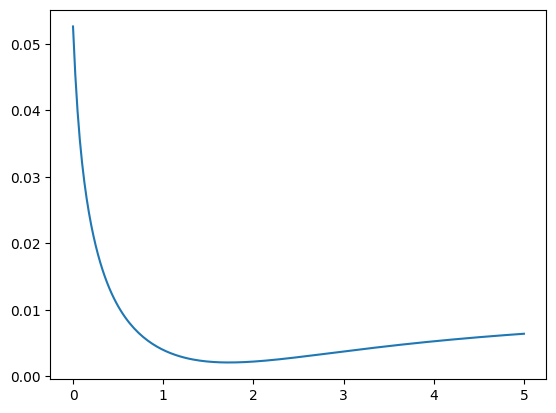

Степень n = 1.7289150835373734


In [8]:
from IPython.display import display, Math

n, A_normed, y_du = n_finder("L1", 110, xfinal, grid_density=10)
print('Степень n = ', n, sep='')
alpha, deviation_max = alpha_finder_of_n(A_normed, y_du, n)

In [12]:
def deviation_analytic(n, alpha, std_pos_normed, std_vel_normed):
    return np.power(alpha[0]*np.power(std_pos_normed, n) + alpha[1]*np.power(std_vel_normed, n), 1/n)

formula = f"d = \\sqrt[{np.around(n, 4)}]{{{np.around(alpha[0], 2)}\\cdot \\sigma_{{pos}}^{{{np.around(n, 4)}}} + {np.around(alpha[1], 2)}\\cdot \\sigma_{{vel}}^{{{np.around(n, 4)}}}}}\\cdot{np.around(du2km(deviation_max), 3)} \\ [km]"

std_pos, std_vel = km2du(0.98), kmS2vu(0.015e-3)
std_pos_max, std_vel_max = km2du(3), kmS2vu(0.03e-3)

print(f"Пробная точка: [sigma_pos = {np.around(du2km(std_pos), 1)} км, sigma_vel = {vu2kms(std_vel)*1000} м/с]")
print(f"Крайние значения данных: [sigma_pos_max = {3} км, sigma_vel_max = {0.03} м/с]")
print('Точное значение: ', du2km(get_maxdeviation_wo_integrate('L1', 110, xfinal, std_pos, std_vel, amount_of_points=15000)))
print('Значение, вычисленное по аппроксимирующей формуле: ', deviation_analytic(n, alpha, std_pos/std_pos_max, std_vel/std_vel_max) * du2km(deviation_max))
display(Math(formula))

Пробная точка: [sigma_pos = 1.0 км, sigma_vel = 0.015000000000000001 м/с]
Крайние значения данных: [sigma_pos_max = 3 км, sigma_vel_max = 0.03 м/с]
Точное значение:  2989.542285483706
Значение, вычисленное по аппроксимирующей формуле:  2645.219535528266


<IPython.core.display.Math object>